In [15]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import os
import sklearn
import sklearn.neighbors
from pathlib import Path
from pandas.api.types import CategoricalDtype
from operator import itemgetter
import matplotlib.pyplot as plt
import torch

import warnings
warnings.filterwarnings('ignore')

# constants
RAW_DATA_PATH = Path('raw_data/')
DATAFRAME_PATH = Path('dataframes/')
MODEL_PATH = Path('model/ncf_model.pt')
TOTAL_TRACKS = 50
NUM_WITHHELD = 25
N_NEIGHBORS = 25
SELECTED_TRACK_FEATURES = ['danceability', 'energy', 'key', 'loudness',
                     'speechiness', 'acousticness', 'instrumentalness',
                     'liveness', 'valence', 'tempo']

In [2]:
# read tracks.h5 which contains tracks with features like danceability, loudness ,... etc
# set type of track_uri to category, to convert string to an int unique id
# rename track_uri to tid and sort values based on tid
tracks_features_df = pd.read_hdf(DATAFRAME_PATH / 'tracks.h5', 'tracks')
cat_type = CategoricalDtype(categories=tracks_features_df.track_uri, ordered=True)
tracks_features_df.track_uri = tracks_features_df.track_uri.astype(cat_type)
tracks_features_df = tracks_features_df.rename(columns={'track_uri':'tid'})
tracks_features_df = tracks_features_df[['tid',*SELECTED_TRACK_FEATURES]].sort_values('tid').reset_index(drop=True)
tracks_features_df.head(5)

,tid,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,spotify:track:3uvsVUrAaGQJCTEUR1S3Sx,0.523,0.422,3,-10.385,0.0270,0.78300,0.005140,0.0898,0.145,129.876
1,spotify:track:0heE5tAAaDQmnGhVDImPl2,0.493,0.594,8,-4.404,0.0378,0.25600,0.000000,0.0759,0.304,123.751
2,spotify:track:3omXshBamrREltcf24gYDC,0.468,0.692,2,-4.015,0.0295,0.02020,0.000002,0.5230,0.561,78.009
3,spotify:track:6TYWE19e35N7Bn5heHwyY6,0.553,0.564,9,-7.072,0.0418,0.03900,0.000000,0.3180,0.310,149.953
4,spotify:track:1xznGGDReH1oQq0xzbwXa3,0.791,0.619,1,-5.886,0.0532,0.00784,0.004230,0.3510,0.371,103.989


In [3]:
# read 10000 playlists from the official spoitfy 1M playlists
# for each playlist, get the tracks and their positions
def make_playlist_dfs(path):
    playlists = []
    playlist_tracks = []
    for file in tqdm(os.listdir(path)):
        if not file.endswith(".json"):
            continue
        with open(path/file) as f:
            js_slice = json.load(f)
            for playlist in js_slice['playlists']:
                if playlist['num_tracks'] > TOTAL_TRACKS:
                    sorted_tracks = sorted(playlist['tracks'], key=itemgetter('pos')) 
                    for track in sorted_tracks[:TOTAL_TRACKS]:
                        yield track['track_uri'], playlist['pid'], track['pos'], track['artist_name'], track['track_name'],playlist['name']
def get_tracks_info(path):
    track_info = []
    playlist_tracks = []
    for row in make_playlist_dfs(path):
        track_info.append([*row[:2],*row[3:]])
        playlist_tracks.append(row[:3])
    p_tracks_df = pd.DataFrame(playlist_tracks,columns = ['tid','pid','pos'])
    p_tracks_df.tid = p_tracks_df.tid.astype(cat_type)
    t_info_df = pd.DataFrame(track_info,columns=['tid','pid','artist_name','track_name','playlist_name']).drop_duplicates(subset=['tid'])
    t_info_df.tid = t_info_df.tid.astype(cat_type)
    return p_tracks_df, t_info_df
        

playlist_tracks_df, tracks_info_df = get_tracks_info(RAW_DATA_PATH)
playlist_tracks_df

100%|██████████| 12/12 [00:02<00:00,  4.18it/s]


,tid,pid,pos
0,spotify:track:3uvsVUrAaGQJCTEUR1S3Sx,7000,0
1,spotify:track:0heE5tAAaDQmnGhVDImPl2,7000,1
2,spotify:track:3omXshBamrREltcf24gYDC,7000,2
3,spotify:track:6TYWE19e35N7Bn5heHwyY6,7000,3
4,spotify:track:1xznGGDReH1oQq0xzbwXa3,7000,4
...,...,...,...
245345,spotify:track:0WQiDwKJclirSYG9v5tayI,4998,45
245346,spotify:track:3n69hLUdIsSa1WlRmjMZlW,4998,46
245347,spotify:track:3ZMv9EzGoteNi5Qnx0KpEO,4998,47
245348,spotify:track:3AA8xNhDC0MpqwkGX3EP5V,4998,48


In [4]:
all_playlist_ids = playlist_tracks_df.pid.unique()
train_pids, test_pids = train_test_split(all_playlist_ids,random_state=0, test_size=0.20)
print(f'total playlists: {len(all_playlist_ids)}')
print(f'train playlists: {len(train_pids)}')
print(f'test playlists: {len(test_pids)}')
# 1. Get tracks that are only from the training playlists
# 2. Get the track features(danceability,loudness) for each of these training tracks
# 3. Make a test set that only includes tracks from the training set
train_playlist_tracks_df = playlist_tracks_df.query('pid in @train_pids')

train_tracks_features_df = tracks_features_df.query('tid in @train_playlist_tracks_df.tid')
test_playlist_tracks_df = playlist_tracks_df.query('pid in @test_pids and tid in @train_playlist_tracks_df.tid')
print()
print(f'total tracks in train playlists: {len(train_playlist_tracks_df)}')
print(f'unique tracks in train playlists: {len(train_tracks_features_df)}')


# 1. Get the first NUM_WITHHELD tracks for each playlist in test
# 2. Get the track features for these with held tracks
# 3. Compute mean features by grouping the tracks from incomplete playlists
test_playlist_tracks_incomplete_df = test_playlist_tracks_df.groupby('pid').head(NUM_WITHHELD)
test_tracks_incomplete_features_df = test_playlist_tracks_incomplete_df.merge(tracks_features_df,how='inner',on='tid')
test_playlist_incomplete_features = test_tracks_incomplete_features_df[['pid',*SELECTED_TRACK_FEATURES]].groupby('pid',as_index=False).mean()
print()
print(f'total tracks in test playlists: {len(test_playlist_tracks_df)}')
print(f'total tracks in incomplete test playlists: {len(test_playlist_tracks_incomplete_df)}')
print(f'total incomplete test playlists: {len(test_playlist_incomplete_features)}')

total playlists: 4907
train playlists: 3925
test playlists: 982

total tracks in train playlists: 196250
unique tracks in train playlists: 71782

total tracks in test playlists: 36534
total tracks in incomplete test playlists: 22919
total incomplete test playlists: 975


In [5]:
tracks_features_df

,tid,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,spotify:track:3uvsVUrAaGQJCTEUR1S3Sx,0.523,0.422,3,-10.385,0.0270,0.78300,0.005140,0.0898,0.1450,129.876
1,spotify:track:0heE5tAAaDQmnGhVDImPl2,0.493,0.594,8,-4.404,0.0378,0.25600,0.000000,0.0759,0.3040,123.751
2,spotify:track:3omXshBamrREltcf24gYDC,0.468,0.692,2,-4.015,0.0295,0.02020,0.000002,0.5230,0.5610,78.009
3,spotify:track:6TYWE19e35N7Bn5heHwyY6,0.553,0.564,9,-7.072,0.0418,0.03900,0.000000,0.3180,0.3100,149.953
4,spotify:track:1xznGGDReH1oQq0xzbwXa3,0.791,0.619,1,-5.886,0.0532,0.00784,0.004230,0.3510,0.3710,103.989
...,...,...,...,...,...,...,...,...,...,...,...
170084,spotify:track:62FaMvOq3vLJTBjb5RgxiO,0.327,0.115,2,-13.907,0.0328,0.97800,0.000020,0.1180,0.0874,95.697
170085,spotify:track:7rWF4voHsXhZ3lx1BgtIjq,0.298,0.164,2,-14.639,0.0382,0.94700,0.306000,0.1390,0.1010,79.968
170086,spotify:track:5YUeOSawPzseEvCvi1HbrE,0.112,0.157,7,-15.906,0.0337,0.72300,0.900000,0.2120,0.0864,92.197
170087,spotify:track:4aAmDp1AR1Fp1UCpWuvy2d,0.169,0.209,4,-14.995,0.0362,0.42000,0.051900,0.0985,0.1020,78.355


In [6]:
# KNN model that will find 25 nearest neighbors to the current playlist
knn_clf = sklearn.neighbors.NearestNeighbors(n_neighbors=NUM_WITHHELD)
knn_clf.fit(train_tracks_features_df[SELECTED_TRACK_FEATURES])
distances, indices = knn_clf.kneighbors(test_playlist_incomplete_features[SELECTED_TRACK_FEATURES])

In [7]:
# for each test playlist, get the 25 next nearest predicted tracks and add them to a table for evaluation
def get_predicted_playlist_tracks():
    for index, row in test_playlist_incomplete_features.iterrows():
            predicted_tracks = train_tracks_features_df['tid'].iloc[indices[index]]
            for pos, predicted_track in enumerate(predicted_tracks):
                yield predicted_track, int(row['pid']),pos

test_predicted_playlist_tracks_df = pd.DataFrame(get_predicted_playlist_tracks(), columns =['tid', 'pid', 'pos'])
test_predicted_playlist_tracks_df.tid = test_predicted_playlist_tracks_df.tid.astype(cat_type)

In [8]:
# coode to get 
one_pid = test_playlist_incomplete_features.sample(1)
one_pid

,pid,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
425,4246,0.69932,0.74188,5.28,-6.04584,0.105472,0.120154,0.026937,0.148824,0.595672,131.33108


In [9]:
tracks_in_one_playlist_df = test_predicted_playlist_tracks_df.query('pid in @one_pid.pid')
tracks_info_in_one_playlist_df = tracks_info_df.query('tid in @tracks_in_one_playlist_df.tid')
print('recommendations for ',tracks_info_df.query('pid in @one_pid.pid')['playlist_name'].head(1).values)
tracks_info_in_one_playlist_df = tracks_info_in_one_playlist_df[['artist_name','track_name']]
tracks_info_in_one_playlist_df['distances'] = distances[one_pid.index].reshape(-1,1)
tracks_info_in_one_playlist_df

recommendations for  ['Hick hop']


,artist_name,track_name,distances
596,Young Thug,Wyclef Jean,0.475697
3082,2 Chainz,No Lie,0.736676
4049,Katy Perry,Dark Horse,0.777869
15921,Iggy Azalea,Change Your Life,0.787689
17142,LANY,like you lots,0.803388
24550,Guster,Satellite,0.813437
36708,Justin Moore,Small Town USA,0.856506
41886,Kraak & Smaak,Squeeze Me - Fedde Le Grand Remix,0.866668
43804,Old Crow Medicine Show,We Don't Grow Tobacco,0.910154
52312,Casting Crowns,If We Are The Body,0.926575


In [10]:
class Evaluator:
    def __init__(self,predicted_playlist_tracks,true_playlist_tracks):
        self.predicted_playlist_tracks = predicted_playlist_tracks
        self.true_playlist_tracks = true_playlist_tracks    

    def evaluate(self):
        predicted_playlist_tracks = self.predicted_playlist_tracks
        true_playlist_tracks = self.true_playlist_tracks
        
        r_precision_list = []
        ndcg_list = []
        song_clicks_list = []
        
        pid_list = true_playlist_tracks.pid.unique()
        
        def get_metrics():
            for pid in tqdm(pid_list):
                predictions = predicted_playlist_tracks.query('pid in @pid_list').tid
                truth = true_playlist_tracks.query('pid in @pid_list').tid
                yield (pid , self.r_precision(predictions,truth),self.ndcg(predictions,truth),self.song_clicks(predictions,truth))
        metrics = pd.DataFrame(get_metrics(),columns=['pid','r_precision','ndcg','songs_click'])
        
        return metrics[['r_precision','ndcg','songs_click']].mean()
         
    def r_precision(self,predictions,truth,n_tracks = N_NEIGHBORS):
        truth_set = set(truth)
        prediction_set = set(predictions[:n_tracks])
        intersect = prediction_set.intersection(truth_set)
        return float(len(intersect)) / len(truth_set)
            
    def ndcg(self,predictions,truth,n_tracks = N_NEIGHBORS):
        predictions = list(predictions[:n_tracks])
        truth = list(truth)   
        score = [float(element in truth) for element in predictions]    
        dcg  = np.sum(score / np.log2(1 + np.arange(1, len(score) + 1)))     
        ones = np.ones([1,len(truth)])
        idcg = np.sum(ones / np.log2(1 + np.arange(1, len(truth) + 1)))
        return (dcg / idcg)
    
    def song_clicks(self,predictions,truth,n_tracks = N_NEIGHBORS):
        predictions = predictions[:n_tracks]
        i = set(predictions).intersection(set(truth))
        for index, t in enumerate(predictions):
            for track in i:
                if t == track:
                    return float(int(index / 10))              
        return float(n_tracks / 10.0 + 1)

In [11]:
model_eval = Evaluator(test_predicted_playlist_tracks_df,test_playlist_tracks_df)
model_eval.evaluate()

100%|██████████| 975/975 [00:34<00:00, 28.27it/s]


r_precision    0.000389
ndcg           0.000985
songs_click    0.000000
dtype: float64

## Neural Network (NeuMF)

In [12]:
from scipy.sparse import dok_matrix

In [13]:
total_playlist_tracks_df = train_playlist_tracks_df.append(test_playlist_tracks_incomplete_df)
unique_tracks = total_playlist_tracks_df['tid'].unique()
total_cat_type = CategoricalDtype(categories=unique_tracks, ordered=True)
total_playlist_tracks_df['tid'] = total_playlist_tracks_df.tid.astype(total_cat_type)
total_playlist_tracks_df['cat_codes'] = total_playlist_tracks_df['tid'].cat.codes

dok_mat_n_rows = total_playlist_tracks_df.shape[0]
dok_mat_n_cols = len(unique_tracks)

dok_mat_rows = total_playlist_tracks_df['pid']
dok_mat_cols = total_playlist_tracks_df['cat_codes']

# Make a dictionary key sparse matrix
dok_mat = dok_matrix((dok_mat_n_rows, dok_mat_n_cols))

# TODO vectorize later if possible
for (pid, cat_code) in tqdm(zip(dok_mat_rows, dok_mat_cols)):
    dok_mat[pid, cat_code] = 1.0

219169it [00:02, 85666.33it/s]


In [34]:
# Hyperparameters
embedding_dim = 8
num_epochs = 2
learning_rate = 0.001
batch_size = 200
rand_negative_fill_in = 4
layer_sizes = [64, 32, 16, 8]

In [62]:
class NeuralMF(torch.nn.Module):
    def __init__(self, num_pl, num_tr, dim=embedding_dim):
        super(NeuralMF, self).__init__()
        num_of_layers = len(layer_sizes)
            
        self.pl_embedding = torch.nn.Embedding(num_pl, dim)
        self.tr_embedding = torch.nn.Embedding(num_tr, dim)
        self.pl_mlp_embedding = torch.nn.Embedding(num_pl, int(layer_sizes[0]/2))
        self.tr_mlp_embedding = torch.nn.Embedding(num_tr, int(layer_sizes[0]/2))
            
        self.mlp = torch.nn.ModuleList()
        for i in range(1, num_of_layers):
            self.mlp.append(torch.nn.Linear(layer_sizes[i - 1], layer_sizes[i]))
            self.mlp.append(torch.nn.ReLU())

        self.affine_final = torch.nn.Linear(dim + layer_sizes[-1], 1)
        self.logistic_sig = torch.nn.Sigmoid()
    
    def init_weight(self):
        torch.nn.init.normal_(self.pl_embedding, std=0.01)
        torch.nn.init.normal_(self.tr_embedding, std=0.01)
        torch.nn.init.normal_(self.pl_mlp_embedding, std=0.01)
        torch.nn.init.normal_(self.tr_mlp_embedding, std=0.01)
        
        for layer in self.mlp:
            if isinstance(layer, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(layer.weight)
                
        torch.nn.init.xavier_uniform_(self.affine_final.weight)
        
        for mod in self.modules():
            if isinstance(mod, torch.nn.Linear) and mod.bias is not None:
                mod.bias.data.zero_()
        
    def forward(self, playlists, tracks):
        pl_vec = self.pl_embedding(playlists)
        tr_vec = self.tr_embedding(tracks)
        prod = torch.mul(pl_vec, tr_vec)
        
        pl_mlp_vec = self.pl_mlp_embedding(playlists)
        tr_mlp_vec = self.tr_mlp_embedding(tracks)
        mlp_vec = torch.cat([pl_mlp_vec, tr_mlp_vec], dim=-1)
        
        for i, layer in enumerate(self.mlp):
            mlp_vec = layer(mlp_vec)
            
        result = self.affine_final(torch.cat([prod,mlp_vec], dim=-1))
        activated_result = self.logistic_sig(result)
        return torch.flatten(activated_result)

In [73]:
model = NeuralMF(dok_mat.shape[0], dok_mat.shape[1])
loss_fn = torch.nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)

def plot_loss(iters, losses):
    plt.plot(iters, losses)
    plt.title(f'Training Curve (batch_size={batch_size}, lr={learning_rate})')
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

def make_train_data():
    for (pl, tr) in dok_mat.keys():
        yield pl, tr, 1.0
        for t in range(rand_negative_fill_in):
            rand_num = np.random.randint(dok_mat.shape[1])
            while(pl, rand_num) in dok_mat.keys():
                rand_num = np.random.randint(dok_mat.shape[1])
            yield pl, rand_num, 0.0

def train_loop(data_loader):
    losses = []; iters = []; offset = 0
    for epoch in range(num_epochs):
        for idx, (pl, tr, recs) in enumerate(data_loader):
            recs = recs.float()
            optim.zero_grad()
            out = model(pl,tr)
            loss = loss_fn(out, recs)
            losses.append(loss)
            iters.append(offset+idx)
            loss.backward()
            optim.step()
        offset = iters[-1]
        print(f'training loss after epoch-{epoch+1} = {(losses[-1]):.4f}')
    return iters, losses

def run_training():
    data_loader = torch.utils.data.DataLoader(list(make_train_data()), batch_size=batch_size)
    iters, losses = train_loop(data_loader)
    plot_loss(iters, losses)

training loss after epoch-1 = 0.3948
training loss after epoch-2 = 0.3367


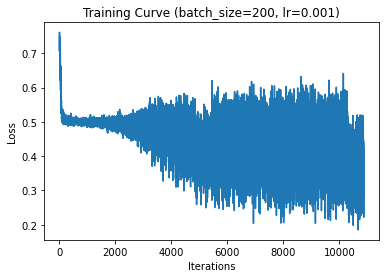

In [74]:
run_training()
torch.save(model.state_dict(), MODEL_PATH)

In [17]:
model = load_model(MODEL_PATH) #🥵👌 

## Make recommendations using the NeuMF model

In [94]:
from sklearn.cluster import KMeans

playlist_for_test = np.random.choice(test_playlist_tracks_df['pid'].tolist())
ground_truth = test_playlist_tracks_df[test_playlist_tracks_df['pid'] == playlist_for_test]

playlist_embedding_weight_matrix = model.pl_mlp_embedding.weight
chosen_playlist_vector = playlist_embedding_weight_matrix[playlist_for_test]

print("Fitting a KMeans model with 100 clusters to the embedding weight matrix for playlists")
km_model = KMeans(n_clusters=100, random_state=0, verbose=0).fit(playlist_embedding_weight_matrix.detach().numpy())

chosen_playlist_vector = chosen_playlist_vector.detach().numpy().reshape(1,-1)
playlist_predictor = km_model.predict(chosen_playlist_vector)
playlist_labels = km_model.labels_

similar_playlists = []
for pid, playlist_label in enumerate(playlist_labels):
    if playlist_label == playlist_predictor:
        similar_playlists.append(pid)
print(f'other playlists in cluster: {len(similar_playlists)}')

Fitting a KMeans model with 100 clusters to the embedding weight matrix for playlists
other playlists in cluster: 2228


In [95]:
from collections import OrderedDict
tracks = []
for pid in similar_playlists:
    tracks += list(total_playlist_tracks_df[total_playlist_tracks_df['pid'] == pid]['cat_codes'])
print(f'other tracks from similar_playlists in cluster: {len(tracks)}') 

tracks = list(OrderedDict.fromkeys(tracks))

pids_pred = torch.tensor(np.full(len(tracks), playlist_for_test, dtype='int32'))
tracks_pred = torch.tensor(np.array(tracks, dtype='int32'))

results = model(pids_pred, tracks_pred)
print("Retrieved predictions from trained model...")

other tracks from similar_playlists in cluster: 1944
Retrieved predictions from trained model...


In [96]:
unique_playlist_tracks_df = total_playlist_tracks_df.drop_duplicates(subset=['cat_codes'])
unique_playlist_tracks_df = unique_playlist_tracks_df.sort_values(by=['cat_codes'], ascending=False)

unique_tids_by_cat_codes = np.array(unique_playlist_tracks_df['tid'])
unique_result_merged = unique_playlist_tracks_df.merge(tracks_info_df, on='tid')
other_features_by_cat_codes = np.array([(row['track_name'],row['artist_name']) for i, row in unique_result_merged.iterrows()])

def get_results_df():
    for i, probability in enumerate(tqdm(results)):
        tid = unique_tids_by_cat_codes[i]
        other_features = other_features_by_cat_codes[i]
        yield probability.item(), tid, *other_features

results_df = pd.DataFrame(get_results_df(), index=range(len(results)), columns=['probability', 'tid','track_name', 'artist_name'])
results_df = results_df.sort_values(by=['probability'], ascending=False)

nmf_preds = results_df.head(NUM_WITHHELD)
nmf_preds

100%|██████████| 1828/1828 [00:00<00:00, 161424.67it/s]


,probability,tid,track_name,artist_name
506,0.937750,spotify:track:0AFJOoRQFlo10Vm1p6BRjg,El calor del amor en un bar,Gabinete Caligari
1372,0.930016,spotify:track:64LVJuh1gZqzWSJZoO4r4U,The Buffalo,Christopher Zondaflex Tyler
374,0.928071,spotify:track:3x9hhPuQ7mo6n7YVLDyzAx,We Cry,The Script
1072,0.926008,spotify:track:26ibKjkmVsOsnk6j9yIj0D,Chains Come Off,Pas Neos
1625,0.923960,spotify:track:0izoPXoz9bo42VjTMPiiRC,Love My Life,DeMarco
1287,0.923041,spotify:track:5AdlQGOi9hKyr0CsBtIat1,Kill The Noise (Part I) - Original Mix,Kill The Noise
17,0.920919,spotify:track:08w1hnWW4GhVm61DoVojsY,Grace,Rag'n'Bone Man
633,0.918577,spotify:track:6cLgmC8xktjSQ2zs4FzBLC,Love Is Here To Stay,Ella Fitzgerald
2,0.918351,spotify:track:78i2I36r9yl95nnG7KERjq,Forever - Hook 'N' Sling Remix,Wolfgang Gartner
150,0.916650,spotify:track:0pIDglczdsnQHVARyoq3Jw,Rightfully So,Knox Hamilton


In [97]:
def predictions_nmf():
    for idx,row in nmf_preds.iterrows():
        yield (row['tid'], playlist_for_test, idx)

predictions_nmf_df = pd.DataFrame(predictions_nmf(), columns=['tid','pid', 'pos'])
nmf_model_eval = Evaluator(predictions_nmf_df, ground_truth.iloc[25:])
nmf_model_eval.evaluate()

100%|██████████| 1/1 [00:00<00:00, 99.79it/s]


r_precision    0.0
ndcg           0.0
songs_click    3.5
dtype: float64

In [98]:
test_playlist_tracks_incomplete_df.query('pid == @playlist_for_test')[['tid','pos']].merge(tracks_info_df, on='tid')

,tid,pos,pid,artist_name,track_name,playlist_name
0,spotify:track:62vpWI1CHwFy7tMIcSStl8,0,7038,J. Cole,No Role Modelz,XO
1,spotify:track:5ByAIlEEnxYdvpnezg7HTX,1,7239,The Notorious B.I.G.,Juicy,old school hip hop
2,spotify:track:7KwZNVEaqikRSBSpyhXK2j,2,7067,The Notorious B.I.G.,Hypnotize - 2014 Remastered Version,viben
3,spotify:track:4INDiWSKvqSKDEu7mh8HFz,3,7067,The Notorious B.I.G.,Mo Money Mo Problems (feat. Mase & Puff Daddy)...,viben
4,spotify:track:0jx8zY5JQsS4YEQcfkoc5C,4,7162,Chance The Rapper,Angels (feat. Saba),kd
5,spotify:track:7yyRTcZmCiyzzJlNzGC9Ol,5,7066,DRAM,Broccoli (feat. Lil Yachty),Driving
6,spotify:track:7FOJvA3PxiIU0DN3JjQ7jT,6,7249,J. Cole,Power Trip,good stuff
7,spotify:track:6JG0qhINKVwiHxqN85j7RG,7,7096,J. Cole,Crooked Smile,chill
8,spotify:track:0B8QzDH7YWih85V5SEMnyJ,8,7145,Lil Uzi Vert,Money Longer,july 2016
9,spotify:track:2ANLarE8yHVsLWW21nj79M,9,7145,Lil Uzi Vert,You Was Right,july 2016


In [99]:
ground_truth[['tid','pos']].merge(tracks_info_df, on='tid')

,tid,pos,pid,artist_name,track_name,playlist_name
0,spotify:track:62vpWI1CHwFy7tMIcSStl8,0,7038,J. Cole,No Role Modelz,XO
1,spotify:track:5ByAIlEEnxYdvpnezg7HTX,1,7239,The Notorious B.I.G.,Juicy,old school hip hop
2,spotify:track:7KwZNVEaqikRSBSpyhXK2j,2,7067,The Notorious B.I.G.,Hypnotize - 2014 Remastered Version,viben
3,spotify:track:4INDiWSKvqSKDEu7mh8HFz,3,7067,The Notorious B.I.G.,Mo Money Mo Problems (feat. Mase & Puff Daddy)...,viben
4,spotify:track:0jx8zY5JQsS4YEQcfkoc5C,4,7162,Chance The Rapper,Angels (feat. Saba),kd
5,spotify:track:7yyRTcZmCiyzzJlNzGC9Ol,5,7066,DRAM,Broccoli (feat. Lil Yachty),Driving
6,spotify:track:7FOJvA3PxiIU0DN3JjQ7jT,6,7249,J. Cole,Power Trip,good stuff
7,spotify:track:6JG0qhINKVwiHxqN85j7RG,7,7096,J. Cole,Crooked Smile,chill
8,spotify:track:0B8QzDH7YWih85V5SEMnyJ,8,7145,Lil Uzi Vert,Money Longer,july 2016
9,spotify:track:2ANLarE8yHVsLWW21nj79M,9,7145,Lil Uzi Vert,You Was Right,july 2016
